<font size="5">__Notebook for testing the reconstrcution of LST1 data.__</font>
<br><br>
<font size="3">This Notebook shows the steps followed within cta-lstchain to reconstruct event data from a corsika-simtelarray file to a dl2 data level, with reconstructed energy, direction and gamma/hadron separation.</font>

In [2]:
from sklearn.externals import joblib
from ctapipe.utils import get_dataset_path
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
sys.path.insert(0, '../')
import lstchain.reco.dl0_to_dl1 as calib
import lstchain.reco.reco_dl1_to_dl2 as reco
import lstchain.visualization.plot_dl2 as lstplot

In [5]:
#Import a simtelarray file with data
#datafile = get_dataset_path('gamma_test_large.simtel.gz')
datafile = "/scratch/bernardos/LST1/Gamma/Point_Prod-3_LaPalma_flashcam-prod3j/gamma_20deg_0deg_run11716___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

In [38]:
#Select LST1 events from the file, calibrate them, extract hillas and timing parameters.
#DL0 -> DL1 
calib.max_events = 500 #Limit the number of events to analyze, to speed the examples
calib.r0_to_dl1(datafile)
output_filename = 'dl1_' + os.path.basename(datafile).split('.')[0] + '.h5'

0


/afs/ciemat.es/user/b/bernardos/GitHub/ctapipe/ctapipe/image/hillas.py:563: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


100
200
300
400


In [39]:
#Take a look at the parameters extracted from the simtelarray file:
data = pd.read_hdf(output_filename,key='events/LSTCam')
print(data.keys())

Index(['disp', 'event_id', 'gps_time', 'hadroness', 'intensity', 'intercept',
       'kurtosis', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az', 'mc_az_tel',
       'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y'],
      dtype='object')


Text(0.5,0,'$log_{10} mc_energy$ (MeV)')

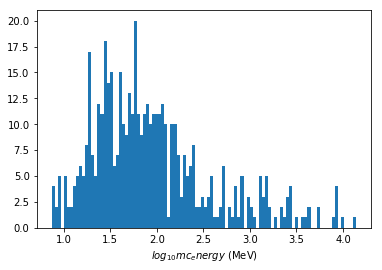

In [40]:
#We can plot some distributions:
plt.hist(data['mc_energy'],bins=100) #Log10(Energy) in MeV
plt.xlabel('$log_{10} mc_energy$ (MeV)')

Text(0.5,0,'$log_{10} intensity$')

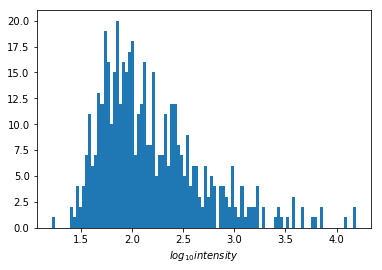

In [41]:
plt.hist(data['intensity'],bins=100) #Log10(intensity(size))
plt.xlabel('$log_{10} intensity$')

Text(0.5,0,'width (º)')

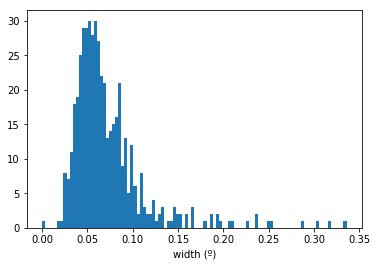

In [42]:
plt.hist(data['width'],bins=100) #Width in deg.
plt.xlabel('width (º)')

Text(0.5,0,'length (º)')

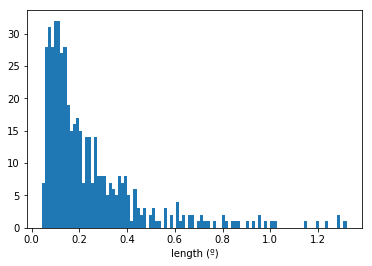

In [43]:
plt.hist(data['length'],bins=100) #Length in deg. 
plt.xlabel('length (º)')

Text(0,0.5,'y (m)')

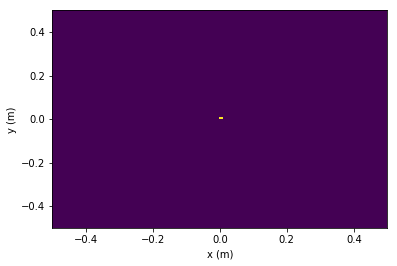

In [44]:
#See the source position: Point gammas or diffuse gammas? (camera coordinates)
plt.hist2d(data['src_x'],data['src_y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0,0.5,'y (m)')

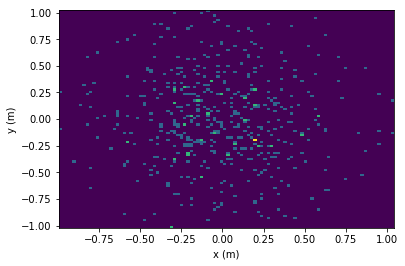

In [45]:
#Position of the hillas ellipse center of gravity (camera coordinates)
plt.hist2d(data['x'],data['y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

In [46]:
#Let's train the Random Forests for Reconstruction
#We must have two files, one with dl1 gamma events and other with dl1 proton events
PATH_EVENTS = "/scratch/bernardos/LST1/Events/"
gammafile = PATH_EVENTS+"gamma_events_point.h5"
protonfile = PATH_EVENTS+"proton_events.h5"
print(gammafile,protonfile)

/scratch/bernardos/LST1/Events/gamma_events_point.h5 /scratch/bernardos/LST1/Events/proton_events.h5


In [47]:
#Define the features to train the RF:
features = ['intensity',                                                                                  
                'time_gradient',                                                                              
                'width',                                                                                      
                'length',                                                                                     
                'wl',                                                                                        
                'phi',                                                                                        
                'psi']
print(features)

['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi']


In [48]:
#Import the trained Random Forests:
#- Two Random Forests Regressors for Energy and disp_(source position) reconstruction
#- One Random Forest Classifier for gamma/hadron separation (uses results from previous RF as new features, e_rec, disp_rec)
from sklearn.externals import joblib

path_models = "../../cta-lstchain-extra/reco/models" #Folder where to find the trained RF

fileE = path_models + "/RFreg_Energy.sav"                                                            
fileD = path_models + "/RFreg_Disp.sav"                                                              
fileH = path_models + "/RFcls_GH.sav"                                                                
                                                                                                              
RFreg_Energy = joblib.load(fileE)                                                                         
RFreg_Disp = joblib.load(fileD)                                                                           
RFcls_GH = joblib.load(fileH)

In [49]:
#Now we have the trained RF that we can use to reconstruct our data into dl2 format:
data_dl2 = reco.ApplyModels(data,features,RFcls_GH,RFreg_Energy,RFreg_Disp)
print(data_dl2.keys())

Index(['disp', 'event_id', 'gps_time', 'hadroness', 'intensity', 'intercept',
       'kurtosis', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az', 'mc_az_tel',
       'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y',
       'e_rec', 'disp_rec', 'src_x_rec', 'src_y_rec', 'hadro_rec'],
      dtype='object')


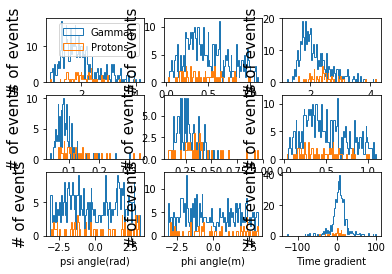

In [50]:
#Lets take a look to the results
lstplot.plot_features(data_dl2)

0.06698903032224612 0.6366944132948744


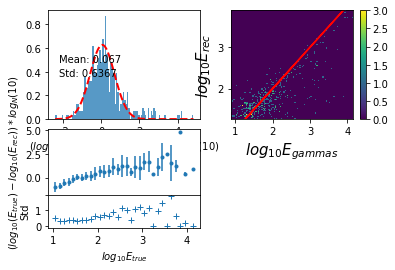

In [51]:
lstplot.plot_e(data_dl2)

0.07055971105672869 0.24620079541582704


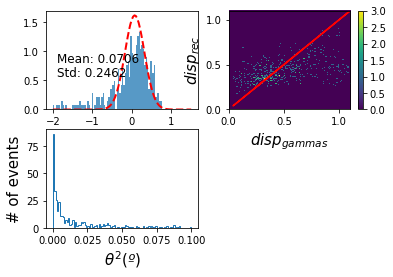

In [52]:
lstplot.plot_disp(data_dl2)

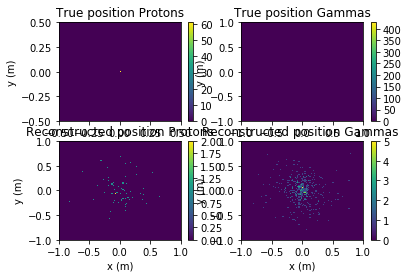

In [53]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

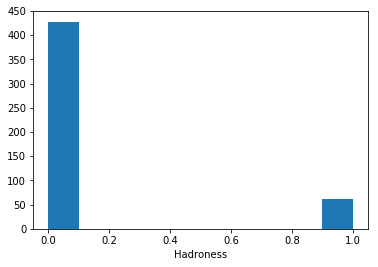

In [54]:
plt.hist(data_dl2['hadro_rec'])
plt.xlabel('Hadroness')